In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from sfd import reddening

from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [2]:
g_ms = GaiaData('../../gd1-dr2/data/gd1-master.fits')

In [3]:
phi1_to_phi2 = np.poly1d(np.load('../../gd1-dr2/output/polytrack.npy'))

In [4]:
w = np.load('../../gd1-dr2/data/stream_model.npy')
stream_w = gd.PhaseSpacePosition(pos=w[:, :3].T*u.kpc,
                                 vel=w[:, 3:].T*u.km/u.s)
model_c = stream_w.to_coord_frame(gc.GD1)
model_c = model_c[(model_c.phi1.wrap_at(180*u.deg) < 20*u.deg) & 
                  (model_c.phi1.wrap_at(180*u.deg) > -100*u.deg)]
model_c_ref = gc.reflex_correct(model_c)

In [5]:
# pts = np.array(np.vstack((g_ms.phi1[g_ms.stream_prob > 0.5],
#                           g_ms.phi2[g_ms.stream_prob > 0.5])).T)
pts = np.array(np.vstack((g_ms.phi1[g_ms.pm_mask & g_ms.gi_cmd_mask],
                          g_ms.phi2[g_ms.pm_mask & g_ms.gi_cmd_mask])).T)

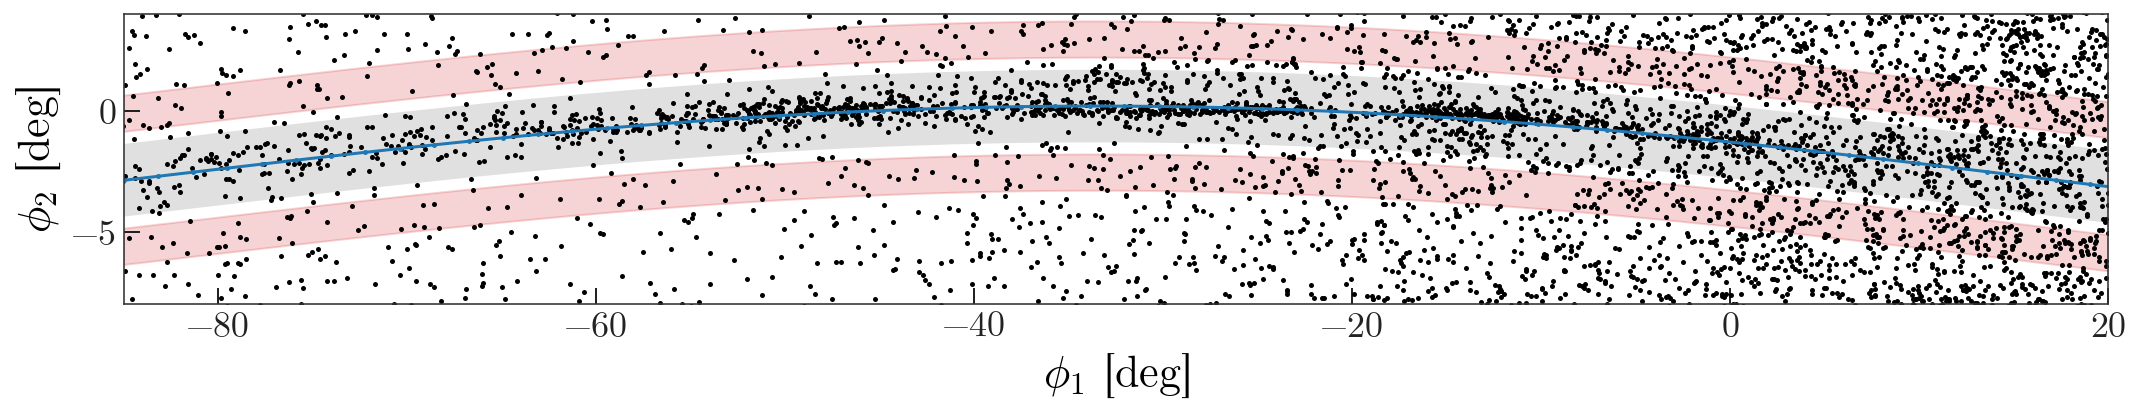

In [6]:
plt.figure(figsize=(15, 3))

plt.plot(pts[:, 0], pts[:, 1], marker='.', ls='none', c='k')

grid = np.linspace(-85, 30, 64)
plt.plot(grid, phi1_to_phi2(grid))

phi12_verts1 = np.vstack((grid, phi1_to_phi2(grid) - 1.5)).T
phi12_verts2 = np.vstack((grid, phi1_to_phi2(grid) + 1.5)).T
phi12_verts = np.vstack((phi12_verts1, phi12_verts2[::-1]))
plt.gca().add_patch(mpl.patches.Polygon(phi12_verts, zorder=-100, alpha=0.2))

phi12_verts1 = np.vstack((grid, phi1_to_phi2(grid) + 2)).T
phi12_verts2 = np.vstack((grid, phi1_to_phi2(grid) + 3.5)).T
off_verts1 = np.vstack((phi12_verts1, phi12_verts2[::-1]))

phi12_verts1 = np.vstack((grid, phi1_to_phi2(grid) - 3.5)).T
phi12_verts2 = np.vstack((grid, phi1_to_phi2(grid) - 2)).T
off_verts2 = np.vstack((phi12_verts1, phi12_verts2[::-1]))

plt.gca().add_patch(mpl.patches.Polygon(off_verts1, zorder=-100, color='tab:red', alpha=0.2))
plt.gca().add_patch(mpl.patches.Polygon(off_verts2, zorder=-100, color='tab:red', alpha=0.2))

# plt.axvline(-38)
# plt.axvline(-22)
# plt.axvline(-19)
# plt.axvline(-8)

plt.xlim(-85, 20)
plt.ylim(-8, 4)

plt.xlabel(r'$\phi_1$ [deg]')
plt.ylabel(r'$\phi_2$ [deg]')

plt.tight_layout()
plt.savefig('../plots/apogee-targeting/gd-1/phi12.png', dpi=250)

In [7]:
class MultiPoly:
    def __init__(self, *polys):
        self.polys = polys
        
    def contains_points(self, X):
        mask = None
        for poly in self.polys:
            if mask is None:
                mask = poly.contains_points(X)
            else:
                mask |= poly.contains_points(X)
                
        return mask
    
on_path = mpl.patches.Path(phi12_verts)
off_path = MultiPoly(mpl.patches.Path(off_verts1), mpl.patches.Path(off_verts2))

In [8]:
X = np.array(np.vstack((g_ms.phi1, g_ms.phi2)).T)
ms_phi_mask = on_path.contains_points(X)
ms_off_phi_mask = off_path.contains_points(X)

In [9]:
# np.save('../../gd1-dr2/output/phi12_poly.npy', phi12_verts)

---

In [10]:
g_giants = GaiaData('../../gd1-dr2/data/gd1-2mass-wise.fits')

In [11]:
c = g_giants.get_skycoord(distance=8*u.kpc, radial_velocity=0*u.km/u.s)
c_gd1 = gc.reflex_correct(c.transform_to(gc.GD1))

phi1 = c_gd1.phi1.wrap_at(180*u.deg)
phi2 = c_gd1.phi2
pm1 = c_gd1.pm_phi1_cosphi2
pm2 = c_gd1.pm_phi2

Polygon selection

In [125]:
X = np.array(np.vstack((phi1, phi2)).T)

phi_mask = on_path.contains_points(X) & (phi1 > -80*u.deg) & (phi1 < 8*u.deg)
off_phi_mask = off_path.contains_points(X) & (phi1 > -80*u.deg) & (phi1 < 8*u.deg)
phi_mask.sum(), off_phi_mask.sum()

(179824, 177225)

In [98]:
orig_pm_poly = np.load('../../gd1-dr2/output/pm_poly.npy')
pm_path1 = mpl.patches.Path(orig_pm_poly)

aggr_pm_poly = np.array([[-9, 1.2],
                         [-3, 1.2],
                         [-3, -1.4],
                         [-9, -1.4]])
pm_path2 = mpl.patches.Path(aggr_pm_poly)

# pm_mask = pm_path1.contains_points(np.vstack((pm1.value, pm2.value)).T)
pm_mask = pm_path2.contains_points(np.vstack((pm1.value, pm2.value)).T)

Make a more aggresive pm polygon because giants are bright!

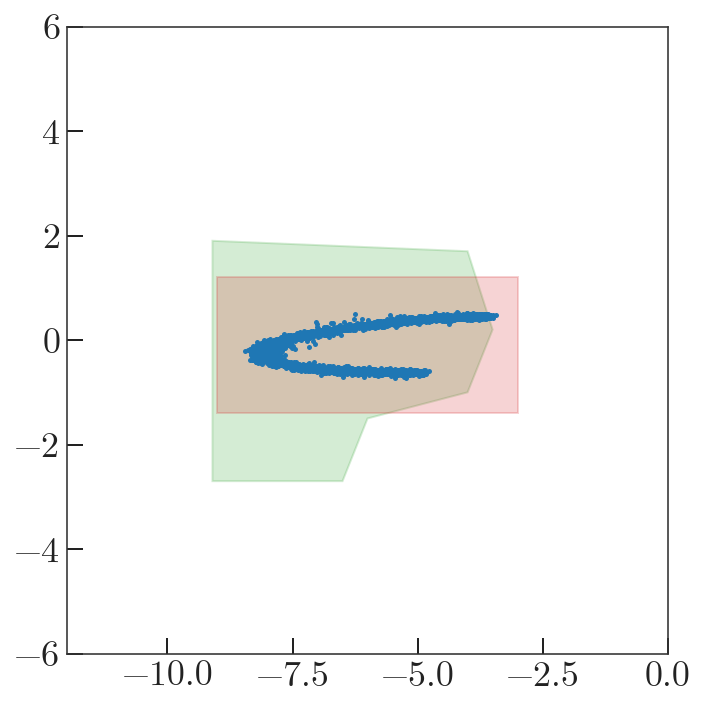

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(model_c_ref.pm_phi1_cosphi2, model_c_ref.pm_phi2, 
        marker='.', ls='none')

ax.add_patch(mpl.patches.Polygon(orig_pm_poly, alpha=0.2, 
                                 zorder=-100, color='tab:green'))

ax.add_patch(mpl.patches.Polygon(aggr_pm_poly, alpha=0.2, 
                                 zorder=-100, color='tab:red'))
    
ax.set_xlim(-12, 0)
ax.set_ylim(-6, 6)

fig.tight_layout()

In [100]:
A2mass = reddening(c, '2MASS', ['J', 'H', 'Ks'])
Aps1 = reddening(c, 'PS1', 'gri')

In [101]:
mag = g_giants.h_m - A2mass[:, 1]
col = g_giants.j_m - g_giants.ks_m - (A2mass[:, 0] - A2mass[:, 2])
mag_mask = mag < 17

# mag = g_giants.h_m - A2mass[:, 1]
# col = g_giants.i_mean_psf_mag - g_giants.ks_m - (Aps1[:, 2] - A2mass[:, 2])
# mag_mask = mag < 17

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [129]:
fehs = [-2, -1.8, -1.6, -1.4]
isos = []
for feh in fehs:
    iso = Table.read('/Users/adrian/data/Isochrones/MIST/FeH_{:.1f}_iso.fits'.format(feh))
    iso = iso[iso['log10_isochrone_age_yr'] == 10.]
    iso = iso[(iso['phase'] < 3) & (iso['phase'] > 0)]
    isos.append(iso)

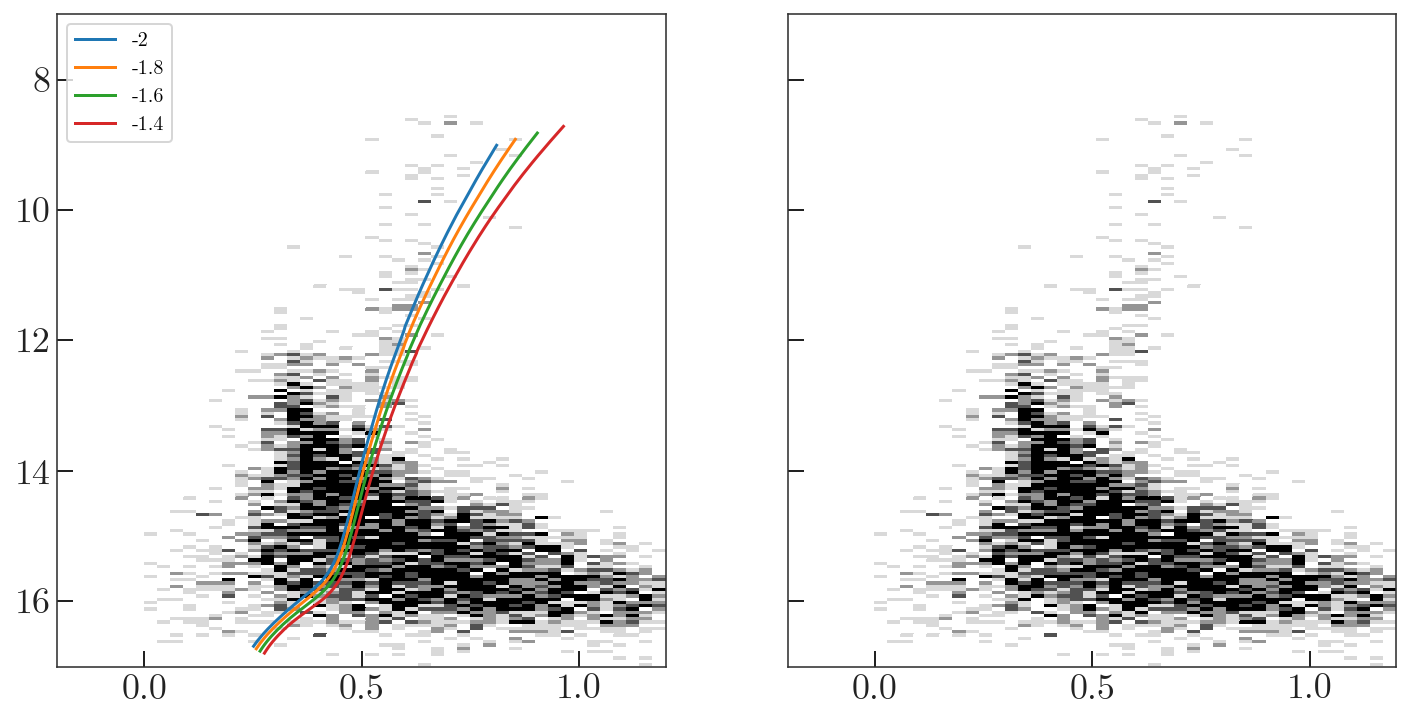

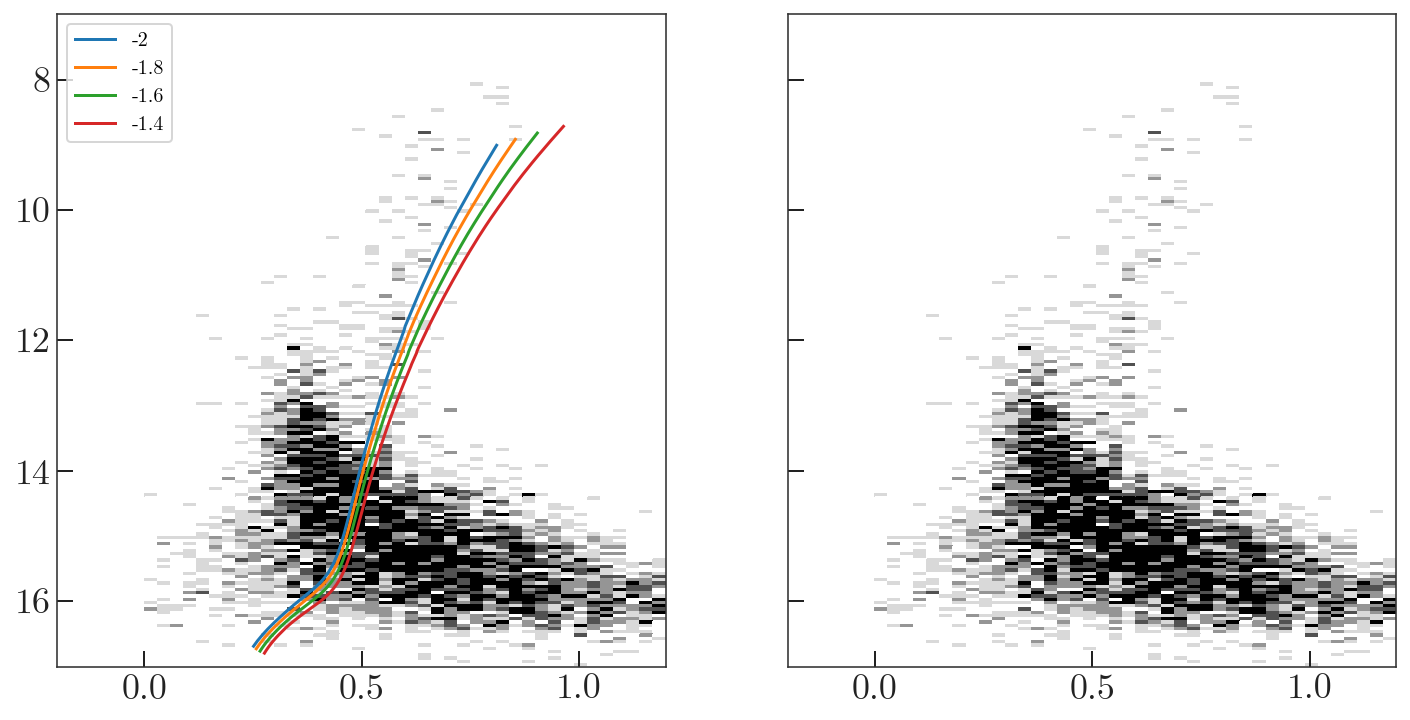

In [130]:
for mask in [phi_mask, off_phi_mask]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    H, xe, ye = np.histogram2d(col[mask & pm_mask & mag_mask],
                               mag[mask & pm_mask & mag_mask],
                               bins=(np.arange(0., 2.5+1e-3, 0.03),
                                     np.arange(8, 18+1e-3, 0.05)))
    for ax in axes:
        ax.pcolormesh(xe, ye, H.T, cmap='Greys', vmin=0, vmax=4)

    for feh, iso in zip(fehs, isos):
        iso_col = iso['J'] - iso['Ks']
        iso_mag = iso['H'] + coord.Distance(8*u.kpc).distmod.value
        axes[0].plot(iso_col, iso_mag, marker='', label=feh)

    axes[0].legend(loc='best')

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(17, 7)

In [131]:
giant_mask = ((mag < 14.) & 
              (col > 0.3) &
              (col < 1.2))

giant_mask.sum()

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


377158

Which ones have already been observed?

In [28]:
apogee_gaia = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
ndim_cols = [x for x in apogee_gaia.columns if apogee_gaia[x].ndim == 1]
apogee_gaia = apogee_gaia[ndim_cols]
apogee_gaia = GaiaData(apogee_gaia[np.array(['GD1' in f for f in apogee_gaia['FIELD']])])
apogee_c = apogee_gaia.get_skycoord(distance=8*u.kpc)
apogee_gd1_c = gc.reflex_correct(apogee_c.transform_to(gc.GD1))

In [132]:
iso_l = isos[0][isos[0]['phase'] == 2]
iso_l = np.vstack((iso_l['J'] - iso_l['Ks'] - 0.08,
                   iso_l['H'] + coord.Distance(7.8*u.kpc).distmod.value - 0.1)).T

# iso_r = isos[-1][isos[-1]['label'] == 3]
# iso_r = np.vstack((iso_r['Jmag'] - iso_r['Ksmag'] + 0.1,
#                    iso_r['Hmag'] + coord.Distance(7.8*u.kpc).distmod.value - 0.1)).T

iso_r = isos[2][isos[2]['phase'] == 2]
iso_r = np.vstack((iso_r['J'] - iso_r['Ks'] + 0.1,
                   iso_r['H'] + coord.Distance(7.8*u.kpc).distmod.value - 0.1)).T

iso_poly_verts = np.vstack((iso_l, iso_r[::-1]))
iso_poly_verts.shape

(302, 2)

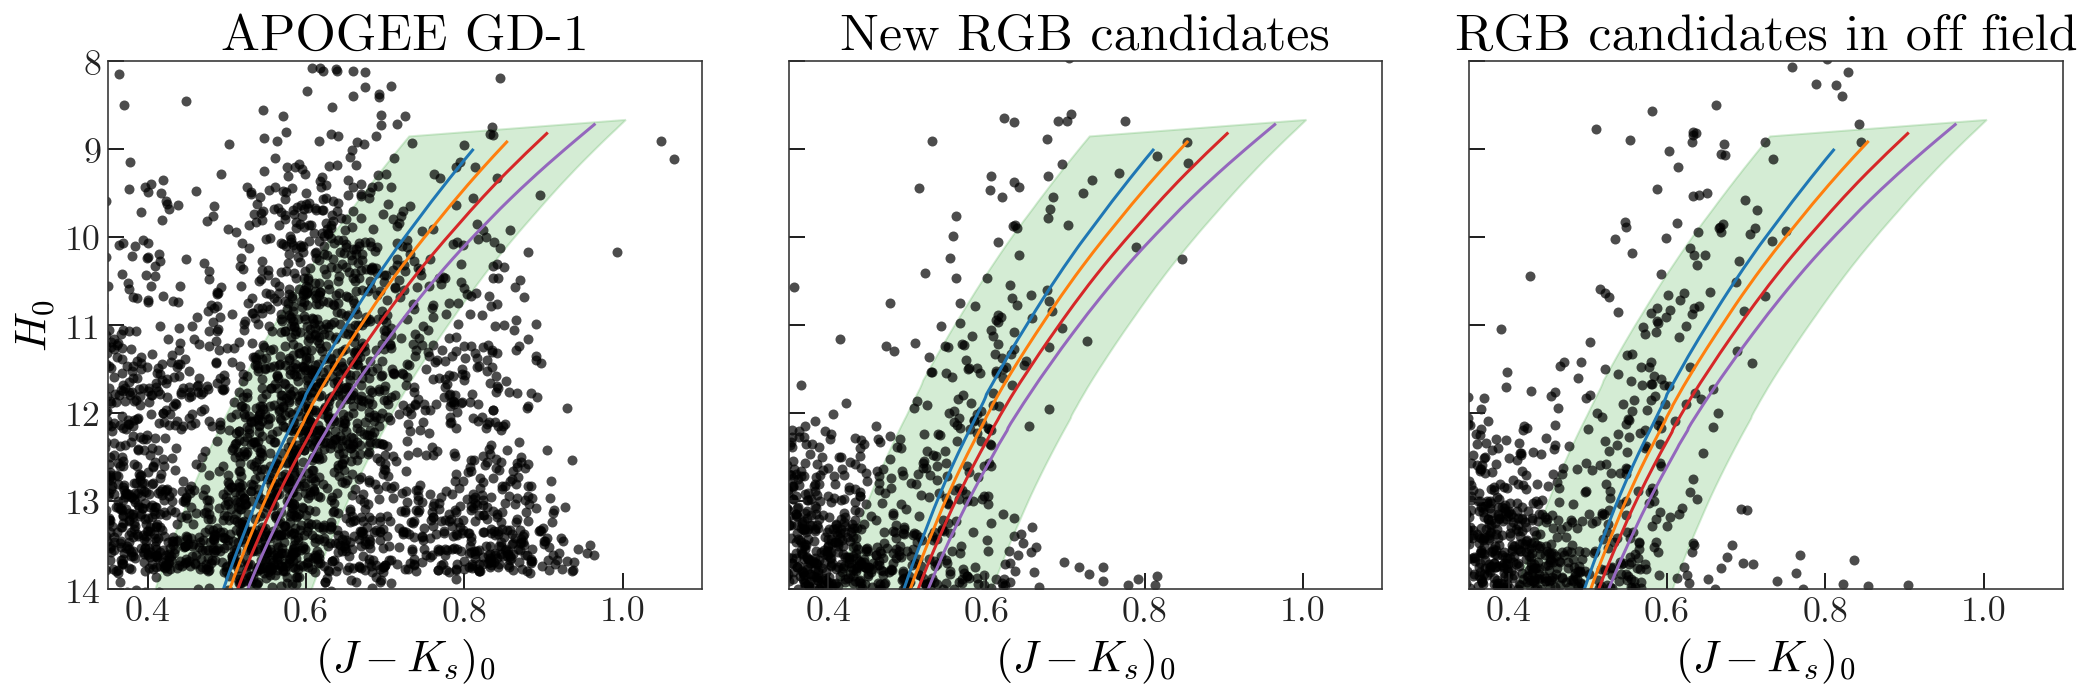

In [133]:
# derp_mask = (phi1[mask & pm_mask & mag_mask] > -60*u.deg) & (phi1[mask & pm_mask & mag_mask] < -10*u.deg)

colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax = axes[0]
ax.scatter(apogee_gaia.J-apogee_gaia.K,
           apogee_gaia.H, 
           color='k', alpha=0.7, lw=0, label=None)
ax.set_title('APOGEE GD-1')

ax = axes[1]
ax.scatter(col[phi_mask & pm_mask & mag_mask & giant_mask],
           mag[phi_mask & pm_mask & mag_mask & giant_mask], 
           color='k', alpha=0.7, lw=0, label=None)
ax.set_title('New RGB candidates')

ax = axes[2]
ax.scatter(col[off_phi_mask & pm_mask & mag_mask & giant_mask],
           mag[off_phi_mask & pm_mask & mag_mask & giant_mask], 
           color='k', alpha=0.7, lw=0, label=None)
ax.set_title('RGB candidates in off field')

for ax in axes:
    for feh, _iso, color in zip(fehs, isos, colors):
        for ph in np.unique(_iso['phase']):
            iso = _iso[_iso['phase'] == ph]
            iso_col = iso['J'] - iso['Ks']

            for d in [8]:
                iso_mag = iso['H'] + coord.Distance(d*u.kpc).distmod.value
                ax.plot(iso_col, iso_mag, marker='', 
                        label='[Fe/H] = {:.1f}'.format(feh), color=color)

    ax.add_patch(mpl.patches.Polygon(iso_poly_verts, alpha=0.2, 
                                     zorder=-100, color='tab:green'))
    ax.set_xlabel('$(J-K_s)_0$')
    
ax.set_xlim(0.35, 1.1)
ax.set_ylim(14, 8)

axes[0].set_ylabel('$H_0$')

fig.tight_layout()

fig.savefig('../plots/apogee-targeting/gd-1/2MASS-cmd.png', dpi=250)

In [134]:
iso_path = mpl.patches.Path(iso_poly_verts)
X = np.vstack((col, mag)).T
iso_mask = iso_path.contains_points(X) & (X[:, 1] < 14.)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


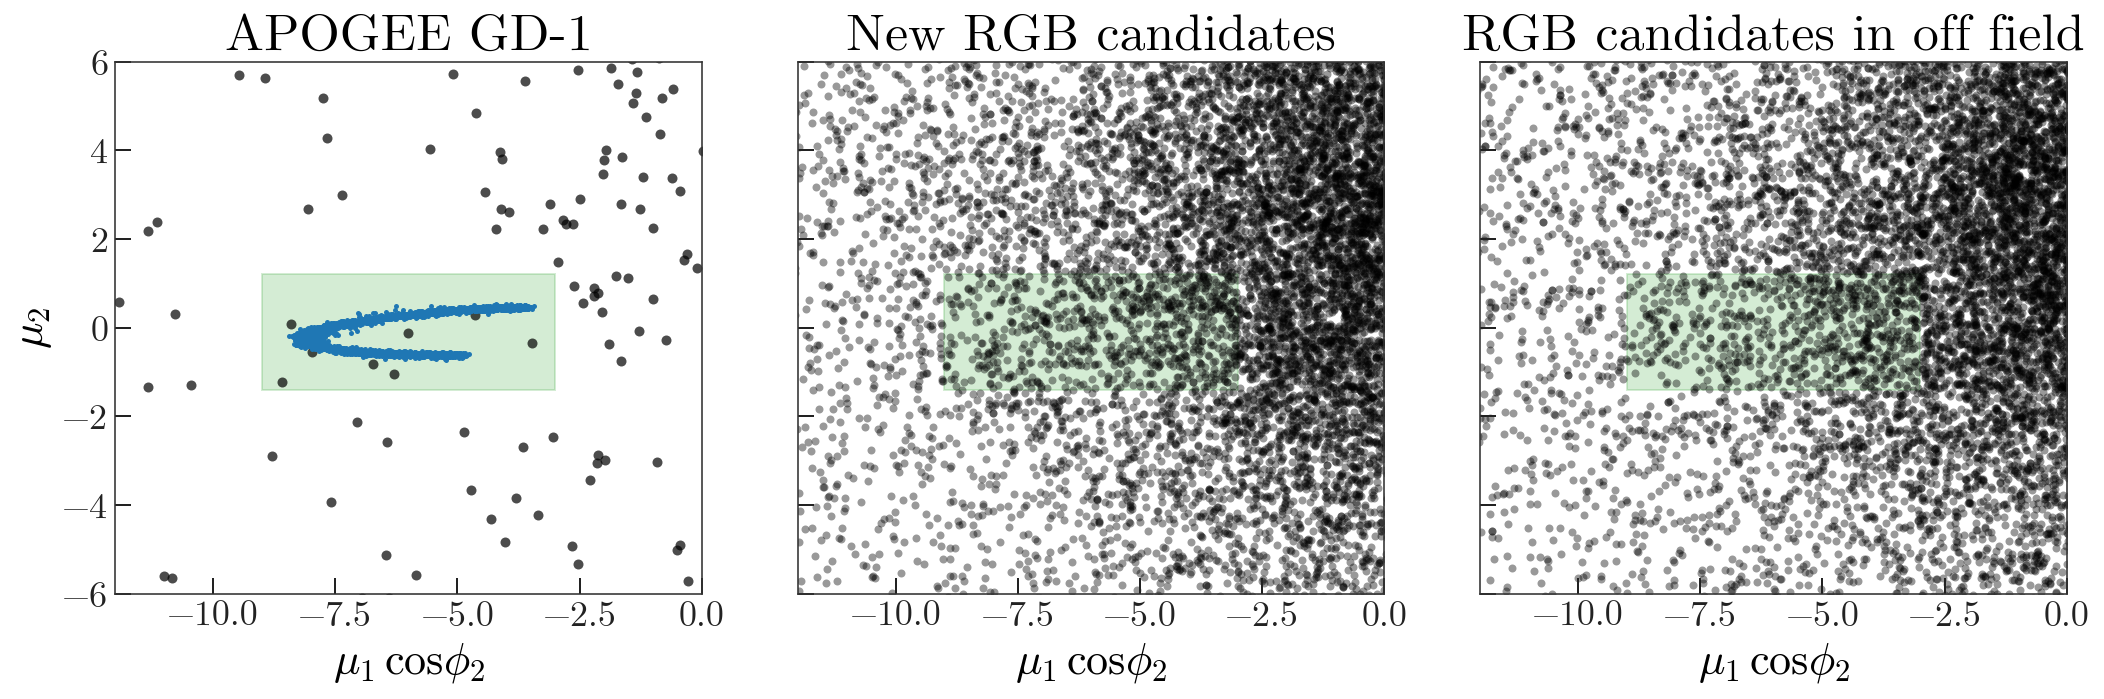

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax = axes[0]
ax.scatter(apogee_gd1_c.pm_phi1_cosphi2,
           apogee_gd1_c.pm_phi2,
           color='k', alpha=0.7, lw=0, label=None)
ax.set_title('APOGEE GD-1')

ax.plot(model_c_ref.pm_phi1_cosphi2, model_c_ref.pm_phi2, 
        marker='.', ls='none')

ax = axes[1]
ax.scatter(c_gd1.pm_phi1_cosphi2[phi_mask & mag_mask & giant_mask],
           c_gd1.pm_phi2[phi_mask & mag_mask & giant_mask], 
           marker='o', color='k', alpha=0.4, lw=0, label=None, s=16)
ax.set_title('New RGB candidates')
# ax.plot(model_c_ref.pm_phi1_cosphi2, model_c_ref.pm_phi2, 
#         marker='.', ls='none')

ax = axes[2]
ax.scatter(c_gd1.pm_phi1_cosphi2[off_phi_mask & mag_mask & giant_mask],
           c_gd1.pm_phi2[off_phi_mask & mag_mask & giant_mask], 
           marker='o', color='k', alpha=0.4, lw=0, label=None, s=16)
ax.set_title('RGB candidates in off field')

for ax in axes:
    ax.add_patch(mpl.patches.Polygon(aggr_pm_poly, alpha=0.2, 
                                     zorder=-100, color='tab:green'))
    ax.set_xlabel(r'$\mu_1 \, \cos\phi_2$')
    
ax.set_xlim(-12, 0)
ax.set_ylim(-6, 6)

axes[0].set_ylabel(r'$\mu_2$')

fig.tight_layout()

fig.savefig('../plots/apogee-targeting/gd-1/pm-sel.png', dpi=250)

In [136]:
from scipy.ndimage import gaussian_filter

In [137]:
X_fg = np.vstack((c_gd1.pm_phi1_cosphi2[phi_mask & mag_mask & giant_mask & iso_mask],
                  c_gd1.pm_phi2[phi_mask & mag_mask & giant_mask & iso_mask])).T
X_bg = np.vstack((c_gd1.pm_phi1_cosphi2[off_phi_mask & mag_mask & giant_mask & iso_mask],
                  c_gd1.pm_phi2[off_phi_mask & mag_mask & giant_mask & iso_mask])).T

bins = (np.arange(-12, 0+1e-3, 0.3),
        np.arange(-6, 6+1e-3, 0.3))
H_fg, xe, ye = np.histogram2d(X_fg[:,0], X_fg[:,1], bins=bins)
H_bg, xe, ye = np.histogram2d(X_bg[:,0], X_bg[:,1], bins=bins)

In [138]:
fac = phi_mask.sum() / off_phi_mask.sum()

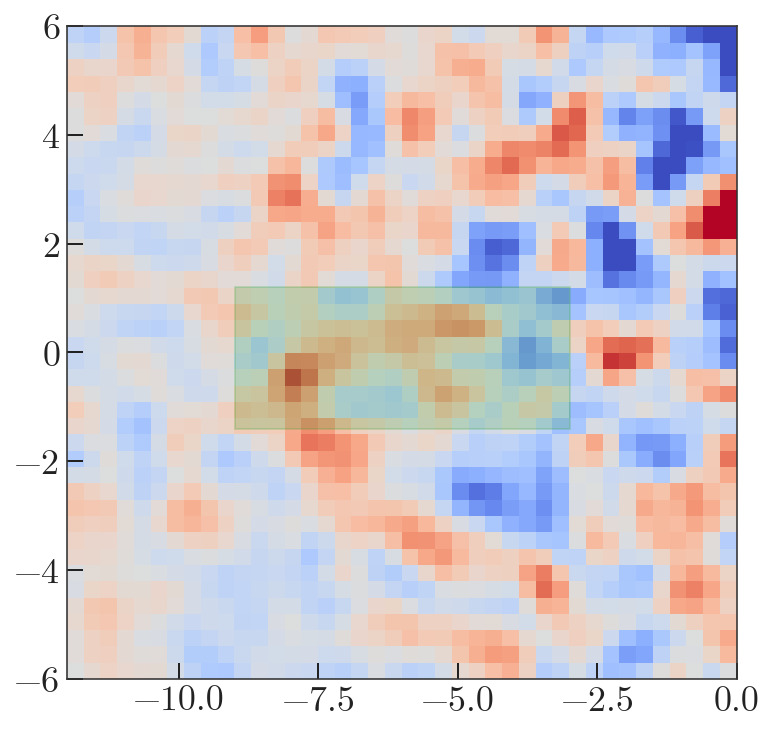

In [139]:
diff = gaussian_filter(H_fg.T, 1.) - gaussian_filter(fac*H_bg.T, 1.)
# diff = H_fg.T - fac*H_bg.T

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(xe, ye, diff, cmap='coolwarm', 
              vmin=-2, vmax=2)
ax.add_patch(mpl.patches.Polygon(aggr_pm_poly, alpha=0.2, 
                                 zorder=100, color='tab:green'))
# ax.plot(model_c_ref.pm_phi1_cosphi2, model_c_ref.pm_phi2, 
#         marker='.', ls='none')

In [140]:
idx, sep, _ = c.match_to_catalog_sky(apogee_c)
prev_sep_mask = sep > 2*u.arcsec
prev_sep_mask.sum()

2509618

In [141]:
(giant_mask & iso_mask & prev_sep_mask).sum()

160057

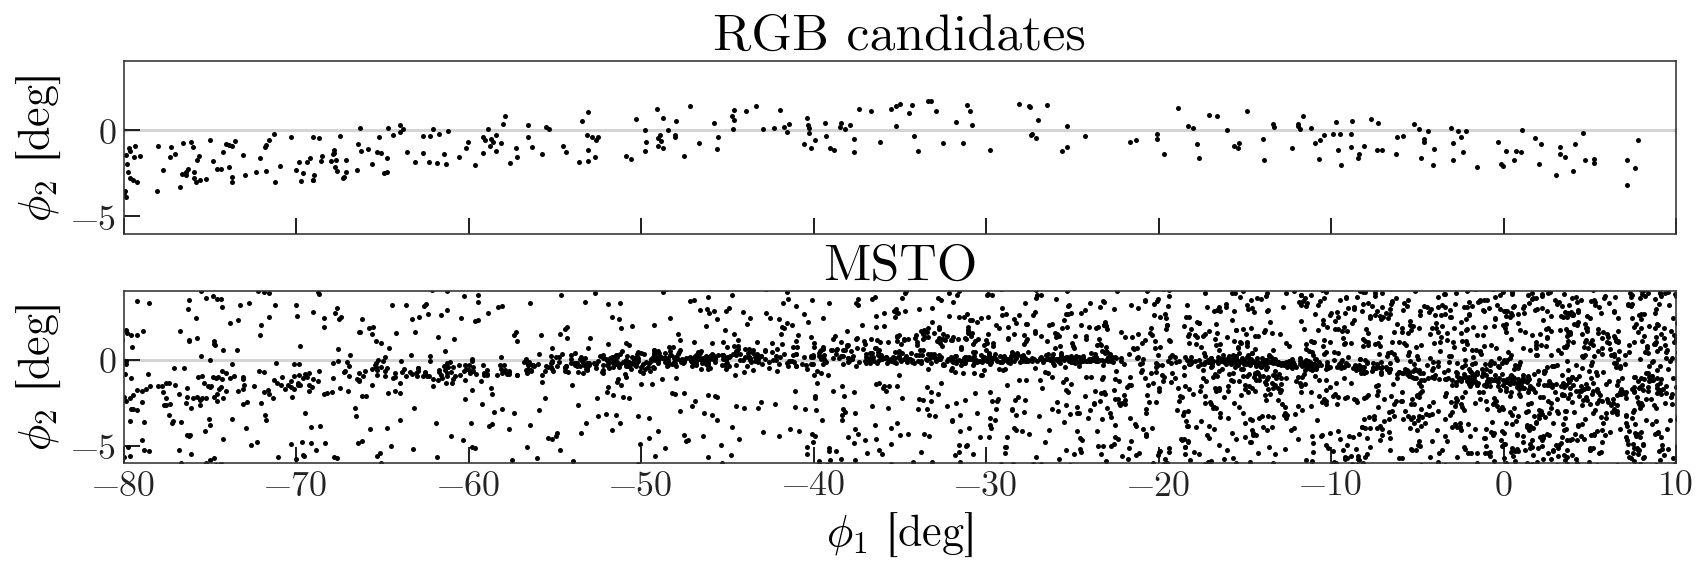

In [146]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4),
                         sharex=True, sharey=True)

axes[0].plot(phi1[phi_mask & pm_mask & mag_mask & giant_mask & iso_mask & prev_sep_mask], 
             phi2[phi_mask & pm_mask & mag_mask & giant_mask & iso_mask & prev_sep_mask], 
             marker='.', ls='none', color='k')
axes[0].set_title('RGB candidates')

axes[1].plot(pts[:, 0], pts[:, 1], marker='.', ls='none', color='k')
axes[1].set_title('MSTO')

axes[0].set_ylabel(r'$\phi_2$ [deg]')
axes[1].set_xlabel(r'$\phi_1$ [deg]')
axes[1].set_ylabel(r'$\phi_2$ [deg]')

for ax in axes:
    ax.axhline(0, zorder=-10, color='#aaaaaa', alpha=0.5)
    ax.set_xlim(-100, 20)
    ax.set_aspect('equal')

ax.set_xlim(-80, 10)
ax.set_ylim(-6, 4)

fig.tight_layout()

fig.savefig('../plots/apogee-targeting/gd-1/RGB-candidates.png', dpi=250)

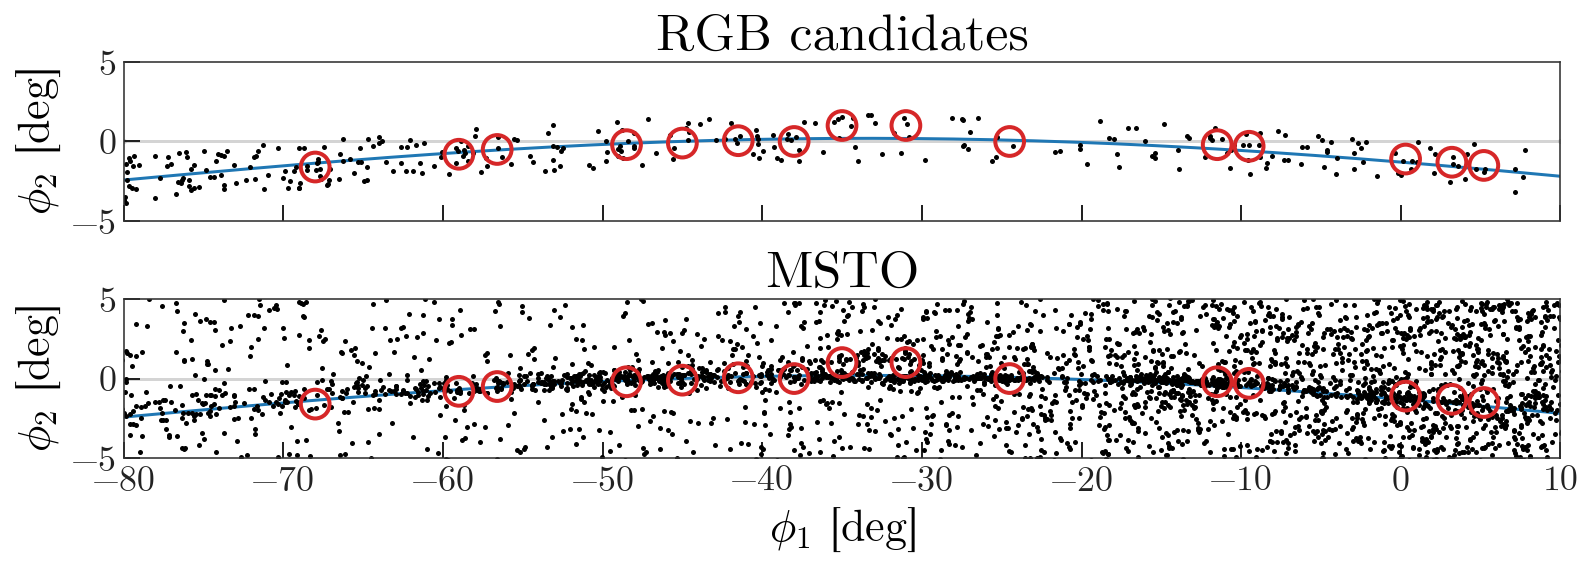

In [147]:
proposed_fields = [(-68, -1.6),
                   (-59, -0.8), (-56.6, -0.5),
                   (-48.5, -0.2),
                   (-45., -0.1), (-41.5, 0.05),
                   (-38, 0), 
                   (-35, 1), (-31, 1),
                   (-24.5, 0),
                   (-11.5, -0.2), (-9.5, -0.3),
                   (0.3, -1.1), (3.2, -1.3), (5.2, -1.5)]

fig, axes = plt.subplots(2, 1, figsize=(15, 4),sharex=True, sharey=True)

axes[0].plot(phi1[phi_mask & pm_mask & mag_mask & giant_mask & iso_mask & prev_sep_mask], 
             phi2[phi_mask & pm_mask & mag_mask & giant_mask & iso_mask & prev_sep_mask], 
             marker='.', ls='none', color='k')
axes[0].set_title('RGB candidates')

# axes[1].plot(pts[:, 0], pts[:, 1], marker='.', ls='none', color='k')
axes[1].plot(g_ms.phi1[g_ms.pm_mask & g_ms.gi_cmd_mask], 
             g_ms.phi2[g_ms.pm_mask & g_ms.gi_cmd_mask], 
             marker='.', ls='none', color='k')

axes[1].set_title('MSTO')

axes[0].set_ylabel(r'$\phi_2$ [deg]')
axes[1].set_xlabel(r'$\phi_1$ [deg]')
axes[1].set_ylabel(r'$\phi_2$ [deg]')

for ax in axes:
    ax.axhline(0, zorder=-10, color='#aaaaaa', alpha=0.5)
    ax.set_xlim(-80, 10)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    
fig.tight_layout()

grid = np.linspace(-120, 40, 128)
for ax in axes:
    ax.plot(grid, phi1_to_phi2(grid), marker='', zorder=-10)
    for field_c in proposed_fields:
        ax.add_patch(mpl.patches.Circle(field_c, radius=0.9, 
                                        zorder=10, facecolor='none', edgecolor='tab:red',
                                        linewidth=2))
        
fig.savefig('../plots/apogee-targeting/gd-1/proposed-fields.png', dpi=250)

In [145]:
len(proposed_fields)

15

### Write out the candidates:

In [270]:
cands = g_giants[phi_mask & pm_mask & mag_mask & giant_mask & iso_mask & prev_sep_mask]
print(len(cands))
cands.data.write('../output/apogee-RGB-GD-1-candidates.fits', overwrite=True)

427


In [274]:
cands.data.colnames

['source_id',
 'ra',
 'dec',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'visibility_periods_used',
 'phot_g_mean_mag',
 'phot_g_mean_flux_over_error',
 'phot_bp_mean_mag',
 'phot_bp_mean_flux_over_error',
 'phot_rp_mean_mag',
 'phot_rp_mean_flux_over_error',
 'phot_bp_rp_excess_factor',
 'astrometric_chi2_al',
 'astrometric_n_good_obs_al',
 'w1mpro',
 'w2mpro',
 'j_m',
 'h_m',
 'ks_m']

In [271]:
H0 = cands.h_m - A2mass[phi_mask & pm_mask & mag_mask & giant_mask & iso_mask & prev_sep_mask, 1]

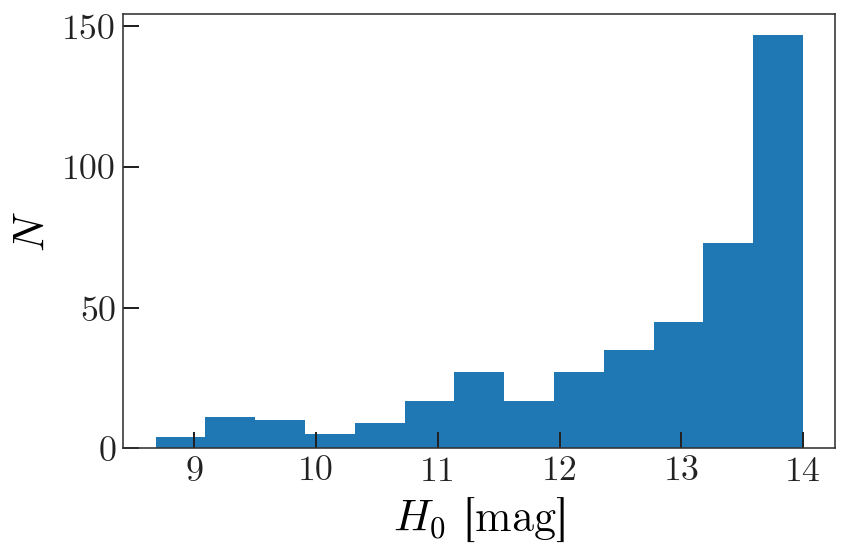

In [273]:
plt.hist(H0, bins='auto');
plt.xlabel('$H_0$ [mag]')
plt.ylabel('$N$')
plt.tight_layout()
plt.savefig('../plots/apogee-targeting/H-mag.png', dpi=250)